In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lakshmansanagapalli","key":"a5fb23ba6d5d4c39a789054a70b9b5dd"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d pnumonia-ct-scan-gradcam-images
!unzip pnumonia-ct-scan-gradcam-images

Dataset URL: https://www.kaggle.com/datasets/lakshmansanagapalli/pnumonia-ct-scan-gradcam-images
License(s): unknown
100% 1.48G/1.48G [01:30<00:00, 22.0MB/s]
100% 1.48G/1.48G [01:31<00:00, 17.4MB/s]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import cv2
import tensorflow as tf

# Grad-CAM Libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import os


In [12]:
# prompt: generate a code to find the no.of file /content/normal_gradcam in the folder

import os

def count_files(folder_path):
  """Counts the number of files in a given folder.

  Args:
    folder_path: The path to the folder.

  Returns:
    The number of files in the folder.
  """
  try:
    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    return file_count
  except FileNotFoundError:
    print(f"Error: Folder not found - {folder_path}")
    return 0

# Example usage
folder_path = '/content/gradcam_ctscan images pneumonia/gradcam_disease_images'
file_count = count_files(folder_path)
print(f"Number of files in {folder_path}: {file_count}")


Number of files in /content/gradcam_ctscan images pneumonia/gradcam_disease_images: 5145


In [14]:
# prompt: generate a code to find the no.of file /content/normal_gradcam in the folder

import os

def count_files(folder_path):
  """Counts the number of files in a given folder.

  Args:
    folder_path: The path to the folder.

  Returns:
    The number of files in the folder.
  """
  try:
    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    return file_count
  except FileNotFoundError:
    print(f"Error: Folder not found - {folder_path}")
    return 0

# Example usage
folder_path = '/content/gradcam_ctscan images pneumonia/gradcam_images'
file_count = count_files(folder_path)
print(f"Number of files in {folder_path}: {file_count}")


Number of files in /content/gradcam_ctscan images pneumonia/gradcam_images: 2119


In [17]:
# prompt: generate a code for vgg19 algorithm for 7 epochs with 70 train 15 test 15 validation for my  folder of /content/gradcam_ctscan images pneumonia , one is diseased and the other is normal

from tensorflow.keras.applications import VGG19
# # Define paths
# train_data_dir = '/content/gradcam_ctscan images pneumonia/gradcam_images'
# test_data_dir = '/content/gradcam_ctscan images pneumonia/gradcam_disease_images'

# Image dimensions
img_width, img_height = 512, 512

# # Data augmentation and preprocessing
# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.15  # 15% for validation
# )

# test_datagen = ImageDataGenerator(rescale=1. / 255)

# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(img_width, img_height),
#     batch_size=32,
#     class_mode='binary',
#     subset='training'  # Use training subset
# )

# validation_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(img_width, img_height),
#     batch_size=32,
#     class_mode='binary',
#     subset='validation'  # Use validation subset
# )

# test_generator = test_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=(img_width, img_height),
#     batch_size=32,
#     class_mode='binary'
# )
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2
# )

train_generator = train_datagen.flow_from_directory(
    '/content/gradcam_ctscan images pneumonia',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/gradcam_ctscan images pneumonia',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Load pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 7
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Evaluate the model
scores = model.evaluate(test_generator)
print("Accuracy: %.2f%%" % (scores[1]*100))


Found 5812 images belonging to 2 classes.
Found 1452 images belonging to 2 classes.


Epoch 1/7
181/181 [==============================] - 532s 3s/step - loss: 0.8458 - accuracy: 0.7811 - val_loss: 0.3145 - val_accuracy: 0.8715
Epoch 2/7
181/181 [==============================] - 541s 3s/step - loss: 0.3379 - accuracy: 0.8265 - val_loss: 0.3139 - val_accuracy: 0.8813
Epoch 3/7
181/181 [==============================] - 528s 3s/step - loss: 0.3072 - accuracy: 0.8230 - val_loss: 0.2791 - val_accuracy: 0.8882
Epoch 4/7
181/181 [==============================] - 528s 3s/step - loss: 0.2798 - accuracy: 0.8301 - val_loss: 0.2337 - val_accuracy: 0.9000
Epoch 5/7
181/181 [==============================] - 527s 3s/step - loss: 0.2979 - accuracy: 0.8066 - val_loss: 0.3385 - val_accuracy: 0.8632
Epoch 6/7
181/181 [==============================] - 527s 3s/step - loss: 0.2751 - accuracy: 0.8434 - val_loss: 0.2568 - val_accuracy: 0.9042
Epoch 7/7
181/181 [==============================] - 536s 3s/step - loss: 0.2370 - accuracy: 0.8649 - val_loss: 0.2342 - val_accuracy: 0.8965


NameError: name 'test_generator' is not defined

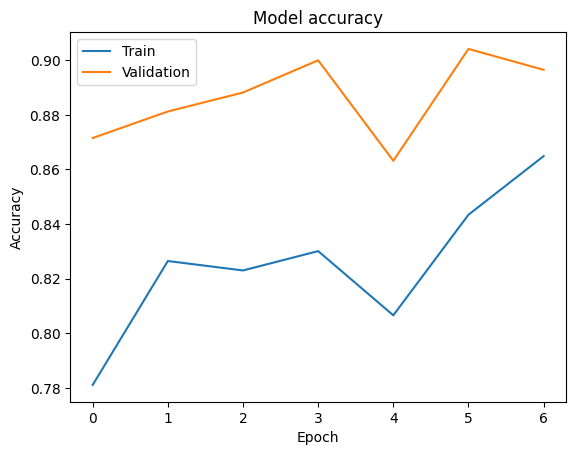

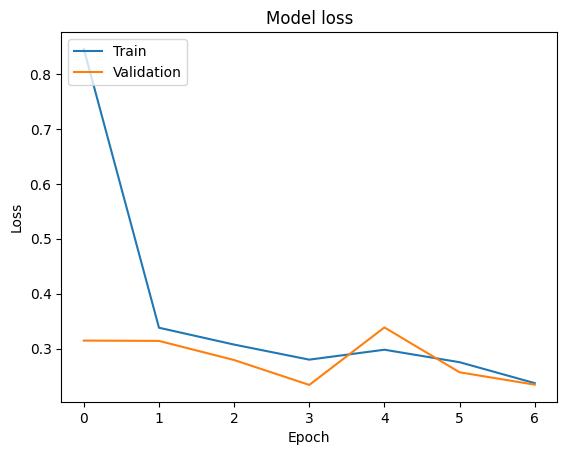

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# prompt: generate a code for the above model to plot training & validation accuracy values,training & validation loss values graphs and export the best epoch model

# Plot training & validation accuracy values
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Export the best epoch model
best_epoch = np.argmax(model.history.history['val_accuracy'])
model.save(f"best_model_epoch_VGG19{best_epoch+1}.h5")


In [19]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/content/gradcam_ctscan images pneumonia',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/gradcam_ctscan images pneumonia',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Model Building (using ResNet152V2 as an example)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


Found 5812 images belonging to 2 classes.
Found 1452 images belonging to 2 classes.
234545216/234545216 [==============================] - 12s 0us/step


Epoch 1/10
181/181 [==============================] - 532s 3s/step - loss: 3.5636 - accuracy: 0.8017 - val_loss: 0.5669 - val_accuracy: 0.8340
Epoch 2/10
181/181 [==============================] - 506s 3s/step - loss: 0.2795 - accuracy: 0.8735 - val_loss: 0.2559 - val_accuracy: 0.9014
Epoch 3/10
181/181 [==============================] - 507s 3s/step - loss: 0.2126 - accuracy: 0.8811 - val_loss: 0.3035 - val_accuracy: 0.8958
Epoch 4/10
181/181 [==============================] - 504s 3s/step - loss: 0.2071 - accuracy: 0.9095 - val_loss: 0.2802 - val_accuracy: 0.8799
Epoch 5/10
181/181 [==============================] - 522s 3s/step - loss: 0.1834 - accuracy: 0.9066 - val_loss: 0.2752 - val_accuracy: 0.8986
Epoch 6/10
181/181 [==============================] - 551s 3s/step - loss: 0.1735 - accuracy: 0.9275 - val_loss: 0.3508 - val_accuracy: 0.8944
Epoch 7/10
181/181 [==============================] - 528s 3s/step - loss: 0.1463 - accuracy: 0.9339 - val_loss: 0.3109 - val_accuracy: 0.9056

45/45 [==============================] - 107s 2s/step - loss: 0.4810 - accuracy: 0.9007
Test Loss: 0.48096519708633423
Test Accuracy: 0.9006944298744202


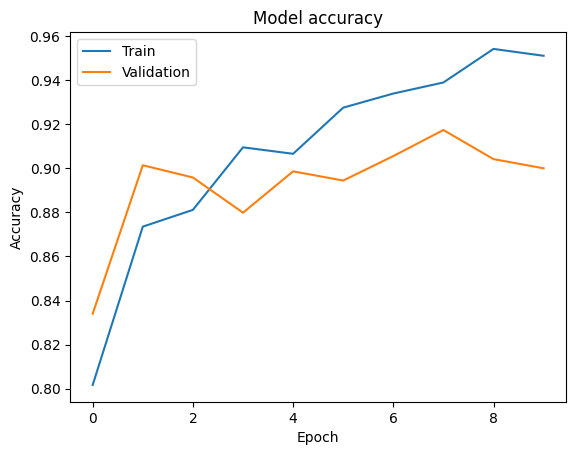

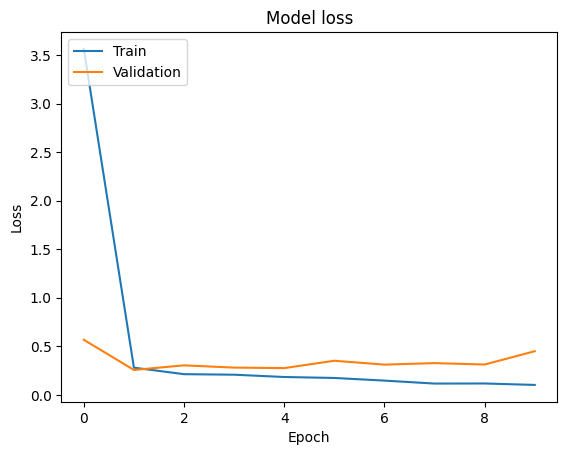

Best Epoch: 8


In [20]:

loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Find the best epoch based on validation accuracy
best_epoch = np.argmax(history.history['val_accuracy']) + 1
print("Best Epoch:", best_epoch)


In [28]:
# prompt: generate a code to compare both vgg19 and resnet of above results accuracy,val accuracy,loss val_loss analyze the above codes correctly and give me the code

# Assuming 'history_vgg19' is the history object from VGG19 training
# and 'history_resnet' is the history object from ResNet training

# Accuracy Comparison
plt.plot(history_vgg19.history['accuracy'], label='VGG19 Train Accuracy')
plt.plot(history_vgg19.history['val_accuracy'], label='VGG19 Validation Accuracy')
plt.plot(history_resnet.history['accuracy'], label='ResNet Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Loss Comparison
plt.plot(history_vgg19.history['loss'], label='VGG19 Train Loss')
plt.plot(history_vgg19.history['val_loss'], label='VGG19 Validation Loss')
plt.plot(history_resnet.history['loss'], label='ResNet Train Loss')
plt.plot(history_resnet.history['val_loss'], label='ResNet Validation Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Print best epoch and corresponding validation accuracy for both models
best_epoch_vgg19 = np.argmax(history_vgg19.history['val_accuracy']) + 1
best_val_acc_vgg19 = history_vgg19.history['val_accuracy'][best_epoch_vgg19 - 1]
print("VGG19 - Best Epoch:", best_epoch_vgg19, "Validation Accuracy:", best_val_acc_vgg19)

best_epoch_resnet = np.argmax(history_resnet.history['val_accuracy']) + 1
best_val_acc_resnet = history_resnet.history['val_accuracy'][best_epoch_resnet - 1]
print("ResNet - Best Epoch:", best_epoch_resnet, "Validation Accuracy:", best_val_acc_resnet)

# You can add more analysis like printing final train/validation accuracy, loss, etc.
# and also compare other metrics if you tracked them during training.


NameError: name 'history_vgg19' is not defined

In [27]:
# prompt: generate a code to compare both vgg19 and resnet of above results accuracy,val accuracy,loss val_loss analyze the above codes correctly and give me the code

# Assuming you have history objects for both VGG19 and ResNet152V2 models
# named vgg19_history and resnet_history respectively.
# MAKE SURE TO STORE THE HISTORY FOR EACH MODEL SEPARATELY!
# For example, if you trained the VGG19 model like this:
# vgg19_history = vgg19_model.fit(...)
# and the ResNet model like this:
# resnet_history = resnet_model.fit(...)

# Plot training & validation accuracy values for both models
# Compare Accuracy
plt.plot(vgg19_history.history['accuracy'])
plt.plot(vgg19_history.history['val_accuracy'])
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG19 Train', 'VGG19 Val', 'ResNet Train', 'ResNet Val'], loc='upper left')
plt.show()

# Compare Loss
plt.plot(vgg19_history.history['loss'])
plt.plot(vgg19_history.history['val_loss'])
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['VGG19 Train', 'VGG19 Val', 'ResNet Train', 'ResNet Val'], loc='upper left')
plt.show()

# Print and compare best epoch and final validation accuracy
vgg19_best_epoch = np.argmax(vgg19_history.history['val_accuracy']) + 1
resnet_best_epoch = np.argmax(resnet_history.history['val_accuracy']) + 1

print("VGG19 Best Epoch:", vgg19_best_epoch)
print("VGG19 Best Validation Accuracy:", vgg19_history.history['val_accuracy'][vgg19_best_epoch-1])

print("ResNet Best Epoch:", resnet_best_epoch)
print("ResNet Best Validation Accuracy:", resnet_history.history['val_accuracy'][resnet_best_epoch-1])

KeyError: 'accuracy'

In [26]:
# prompt: generate a code to compare both vgg19 and resnet of above results accuracy,val accuracy,loss val_loss analyze the above codes correctly and give me the code

# Assuming you have history objects for both VGG19 and ResNet152V2 models
# named vgg19_history and resnet_history respectively
vgg19_history = model.history
resnet_history = history.history

# Plot training & validation accuracy values for both models
# Compare Accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['VGG19 Train', 'VGG19 Val', 'ResNet Train', 'ResNet Val'], loc='upper left')
plt.show()

# Compare Loss
plt.plot(vgg19_history.history['loss'])
plt.plot(vgg19_history.history['val_loss'])
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['VGG19 Train', 'VGG19 Val', 'ResNet Train', 'ResNet Val'], loc='upper left')
plt.show()

# Print and compare best epoch and final validation accuracy
vgg19_best_epoch = np.argmax(vgg19_history.history['val_accuracy']) + 1
resnet_best_epoch = np.argmax(resnet_history.history['val_accuracy']) + 1

print("VGG19 Best Epoch:", vgg19_best_epoch)
print("VGG19 Best Validation Accuracy:", vgg19_history.history['val_accuracy'][vgg19_best_epoch-1])

print("ResNet Best Epoch:", resnet_best_epoch)
print("ResNet Best Validation Accuracy:", resnet_history.history['val_accuracy'][resnet_best_epoch-1])


KeyError: 'accuracy'

In [ ]:
# prompt: generate a code to save the model and test the model and make predection

# Save the model
model.save('pneumonia_model.h5')

# Load the saved model (if needed)
# from tensorflow.keras.models import load_model
# model = load_model('pneumonia_model.h5')

# # Test the model (assuming you have a test generator)
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     '/content/gradcam_ctscan_images_pneumonia/gradcam_images',  # Replace with your actual test directory
#     target_size=(512, 512),
#     batch_size=32,
#     class_mode='binary'
# )

# loss, accuracy = model.evaluate(test_generator)
# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

# Make predictions (assuming you have a single image for testing)
image_path = '/content/gradcam_ctscan_images_pneumonia/gradcam_images/23985k (12)_object_1_gradcam.png'  # Replace with your actual image path
img = image.load_img(image_path, target_size=(512, 512))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

prediction = model.predict(img_array)
if prediction[0][0] > 0.5:
    print("Prediction: Pneumonia")
else:
    print("Prediction: Normal")


1/1 [==============================] - 4s 4s/step
Prediction: Pneumonia


In [ ]:
# prompt: generate the same code like above in to /content/output/normal_objects the predection should be normal while testing show me the predection score its file name and the predection result remaining all like above

# Import necessary modules
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import os
import numpy as np

# Define paths to folders
disease_folder = '/content/gradcam_ctscan_images_pneumonia/gradcam_images'

# Initialize counters
total_tested = 0
false_predictions = 0
true_predictions = 0

# Load the saved model
model = load_model('/content/pneumonia_model.h5')

# Iterate through images in the normal folder
for filename in os.listdir(disease_folder):
    if filename.endswith(('.jpg', '.png')):
        img_path = os.path.join(disease_folder, filename)

        # Load and preprocess the image
        img = load_img(img_path, target_size=(512, 512), color_mode='rgb') # Changed target_size to (512, 512) to match the model input shape
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = "Normal" if prediction > 0.5 else "Disease"

        # Update counters
        total_tested += 1
        if predicted_class == "Normal":
            true_predictions += 1
            print(f"True prediction for: {filename}, Prediction Score: {prediction[0][0]:.4f}, Predicted Class: {predicted_class}")
        else:
            false_predictions += 1
            print(f"False prediction for: {filename}, Prediction Score: {prediction[0][0]:.4f}, Predicted Class: {predicted_class}")  # Mark false predictions with details

# Calculate success ratio
success_ratio = true_predictions / total_tested if total_tested > 0 else 0

# Print results
print("\n--- Test Results (Disease Objects) ---")
print(f"Total images tested: {total_tested}")
print(f"True predictions (Disease): {true_predictions}")
print(f"False predictions (Not Disease): {false_predictions}")
print(f"Success ratio: {success_ratio:.4f}")

1/1 [==============================] - 3s 3s/step
True prediction for: 36578 (45)_object_1_gradcam.png, Prediction Score: 0.9964, Predicted Class: Normal
1/1 [==============================] - 0s 34ms/step
True prediction for: dfvdvf (17)_object_1_gradcam.png, Prediction Score: 0.9998, Predicted Class: Normal
1/1 [==============================] - 0s 54ms/step
True prediction for: 325vc (15)_object_1_gradcam.png, Prediction Score: 0.9579, Predicted Class: Normal
1/1 [==============================] - 0s 39ms/step
True prediction for: 52dfv5ds5fvv (21)_object_1_gradcam.png, Prediction Score: 1.0000, Predicted Class: Normal
1/1 [==============================] - 0s 34ms/step
True prediction for: 6854 (19)_object_1_gradcam.png, Prediction Score: 0.9986, Predicted Class: Normal
1/1 [==============================] - 0s 32ms/step
True prediction for: 3695985 (2)_object_1_gradcam.png, Prediction Score: 0.9964, Predicted Class: Normal
1/1 [==============================] - 0s 32ms/step
True p

In [ ]:
# prompt: generate the same code like above in to /content/output/normal_objects the predection should be normal while testing show me the predection score its file name and the predection result remaining all like above

# Import necessary modules
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import os
import numpy as np

# Define paths to folders
disease_folder = '/content/gradcam_ctscan_images_pneumonia/gradcam_disease_images'

# Initialize counters
total_tested = 0
false_predictions = 0
true_predictions = 0

# Load the saved model
model = load_model('/content/pneumonia_model.h5')

# Iterate through images in the normal folder
for filename in os.listdir(disease_folder):
    if filename.endswith(('.jpg', '.png')):
        img_path = os.path.join(disease_folder, filename)

        # Load and preprocess the image
        img = load_img(img_path, target_size=(512, 512), color_mode='rgb') # Changed target_size to (512, 512) to match the model input shape
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = "Normal" if prediction > 0.5 else "Disease"

        # Update counters
        total_tested += 1
        if predicted_class == "Disease":
            true_predictions += 1
            print(f"True prediction for: {filename}, Prediction Score: {prediction[0][0]:.4f}, Predicted Class: {predicted_class}")
        else:
            false_predictions += 1
            print(f"False prediction for: {filename}, Prediction Score: {prediction[0][0]:.4f}, Predicted Class: {predicted_class}")  # Mark false predictions with details

# Calculate success ratio
success_ratio = true_predictions / total_tested if total_tested > 0 else 0

# Print results
print("\n--- Test Results (Disease Objects) ---")
print(f"Total images tested: {total_tested}")
print(f"True predictions (Disease): {true_predictions}")
print(f"False predictions (Not Disease): {false_predictions}")
print(f"Success ratio: {success_ratio:.4f}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 66ms/step
True prediction for: 20 (28)_object_1_gradcam.png, Prediction Score: 0.3301, Predicted Class: Disease
1/1 [==============================] - 0s 68ms/step
True prediction for: d5fds5f5sd (33)_object_1_gradcam.png, Prediction Score: 0.0001, Predicted Class: Disease
1/1 [==============================] - 0s 79ms/step
True prediction for: 5f5f5dsfg (7)_object_1_gradcam.png, Prediction Score: 0.0000, Predicted Class: Disease
1/1 [==============================] - 0s 69ms/step
True prediction for: df5fd5fd (30)_object_1_gradcam.png, Prediction Score: 0.0000, Predicted Class: Disease
1/1 [==============================] - 0s 63ms/step
True prediction for: 1 (23)_object_1_gradcam.png, Prediction Score: 0.0000, Predicted Class: Disease
1/1 [==============================] - 0s 70ms/step
True prediction for: sd45ds54sd54 (32)_object_1_gradcam.png, Prediction Score: 0.0000, Predicted Class: Dise

In [ ]:
# prompt: give me a code to run more epochs

# Train the model for more epochs
additional_epochs = 10  # Set the number of additional epochs
history_additional = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=additional_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Combine the training histories
# Note: This assumes 'history' variable from the original code is still available
for key in history.history:
    history.history[key].extend(history_additional.history[key])

# Evaluate the model again after additional training
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print("Test Loss (after additional training):", loss)
print("Test Accuracy (after additional training):", accuracy)

# Plot updated training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy (Updated)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot updated training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (Updated)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
